<center>
<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
</center>
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 10 Tutorial: LightGBM, XGBoost, and CatBoost</h2>
<br>



Gradient boosting is one the most powerful algorithms available for supervised learning. For many business applications, carefully tuned boosted trees are likely to be among the best models immediately available for prediction.

A large scale empirical study by [Caruana and Niculescu-Mizil (2006)](https://dl.acm.org/ft_gateway.cfm?id=1143865&ftid=364245&dwn=1&CFID=7573757&CFTOKEN=aea5af1b7b29f94-E2D75B9E-EE4F-186B-FF2FDBF1F8C435D1) found that boosting was overall the most accurate algorithm for supervised learning across a variety of datasets, among competitors that included random forests, support vector machines, and neural networks.  Boosting is also behind [winning solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) to several machine learning competitions. 

In this lesson we will study a regression problem to illustrate how to using boosting with Python. Due to the importance of this topic, we will move beyond scikit-Learn to consider three specialised packages for boosting: [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html), [LightGBM](https://github.com/Microsoft/LightGBM), and [CatBoost](https://catboost.ai/).  

<a href="#1.-California-Housing-Data">California Housing Data</a> <br>
<a href="#2.-Exploratory-data-analysis">Exploratory Data Analysis</a> <br>
<a href="#3.-Random forest">Boosting</a> <br>
<a href="#4.-LightGBM:-a-deeper-dive<">LightGBM: a deeper dive</a> <br>
<a href="#5.-Benchmark-Models">Benchmark models</a> <br>
<a href="#6.-Model-selection">Model selection</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LinearRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

In [4]:
# Useful code from the last tutorial 

from tutorial9 import plot_feature_importance

# 1. California Housing Data

We use the California housing dataset, which we can obtain directly from the Scikit-Learn distribution. 

In [5]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
# Auxiliary code - important to understand but similar to previous tutorials

data = pd.DataFrame(np.c_[data.data, data.target], columns = data.feature_names + ['MedianHouseValue'])
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The following cell identifies the variables and splits the data into training and test samples. Note that: 

* The training set is only a small fraction of the data. This is to reduce the running times during our session, since the original dataset is large (20,640 observations) and methods such as random forests and boosting are computationally intensive.<br/>

* The response is very right skewed, so that we work with work with its log transformation. 

In [7]:
# Auxiliary code - important to understand but similar to previous tutorials

response = data.columns[-1] # last column in the dataframe
predictors= list(data.columns[:-1]) # all columns except the last
    
index_train, index_valid  = train_test_split(np.array(data.index), train_size = 0.2, random_state=1)

train = data.loc[index_train,:].copy()
valid =  data.loc[index_valid,:].copy()

y_train = np.log(train[response])
y_valid = np.log(valid[response])

X_train = train[predictors].to_numpy()
X_valid = valid[predictors].to_numpy()

# 2. Some EDA

A key feature of this dataset is the presence of geographical information. The next cell draws a map to allow us to visualise the relationship between location and median house prices.  Warmer colours indicate higher prices, while the size of the bubbles indicates the population of the area.  

As we might expect, house prices are higher near the coast, around the Bay area, and around Los Angeles.  As we will see, these geographical patterns will be crucial achieving higher predictive accuracy. 

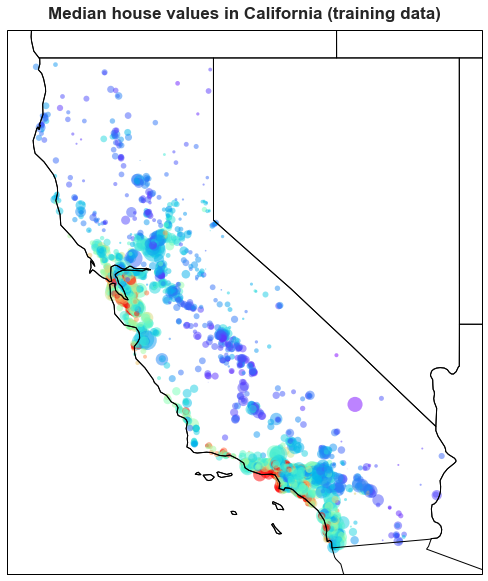

In [8]:
# This code is just for running - advanced code

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Latitude and longitude for the edges of the map
lat1, lat2, lon1, lon2 = 32, 42.5, -125, -114

# Create figures
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator())

# Get latitude and longitude for each data point
x, y = (train['Longitude'].to_numpy(), train['Latitude'].to_numpy())

# Scatter plot as heat map
ax.scatter(x, y, s=(train['Population'].to_numpy()/30.0), c=train['MedianHouseValue'].to_numpy(), 
           edgecolors='none', cmap=plt.get_cmap('rainbow'), alpha=0.5, transform=ccrs.PlateCarree())

# Add state borders and coast line
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([-125, -113.5, 32, 42.5], crs=ccrs.PlateCarree())

# Add title
ax.set_title('Median house values in California (training data)', fontsize=17, y=1.01, fontweight='bold')

plt.show()

The two variables with strongest linear relationship with house values are the median income and the average occupancy. Further exploration through the scatter plots below reveal nonlinear patterns for the median income, average rooms, and average occupancy. Population, housing average age, and average bedrooms seem to have only weak relationships with house values. 

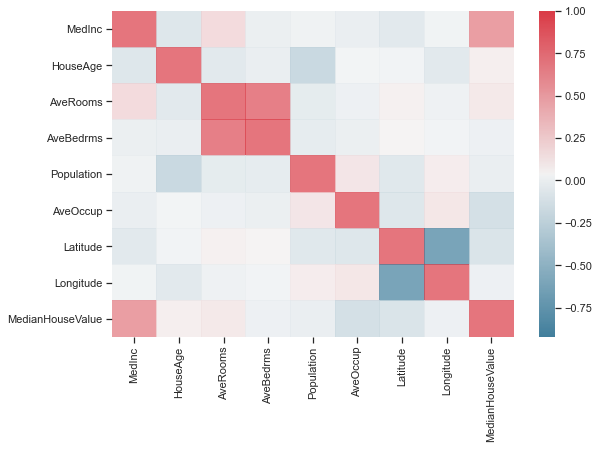

In [9]:
# This code is just for running - we need the figure to support the discussion

sns.heatmap(train.corr(), cmap=sns.diverging_palette(230, 10, n=1001), alpha=0.7)
plt.show()

The next cell shows the scatter plots for the predictors other than the latitude and longitude. We observe severe outliers in some of them, which as we will see below causes serious problems for the linear regression model. In contrast, tree-based methods are outliers in the predictor space.  We can also that the values of the `MedInc` response variable and `HouseAge` are truncated.

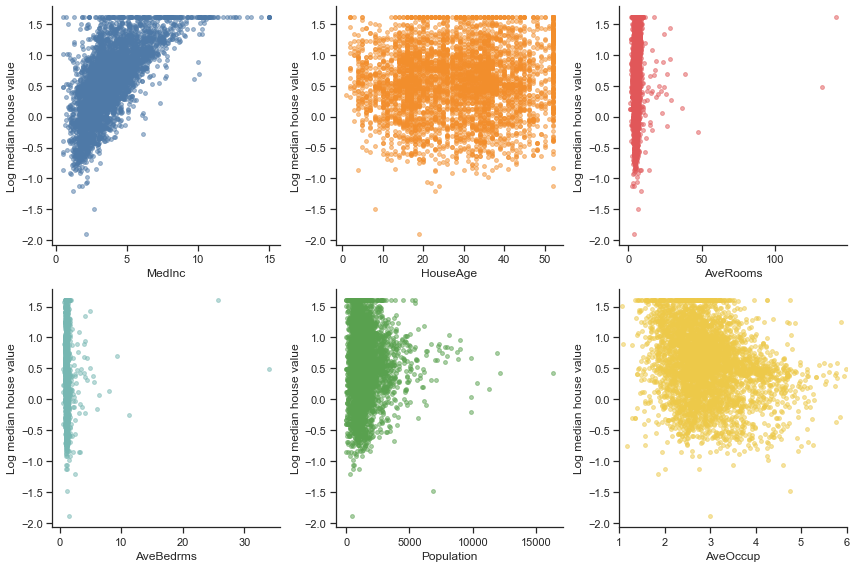

In [10]:
# This code is  just for running - we need the figure to support the discussion

fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, ax in enumerate(fig.axes):
    sns.regplot(train.iloc[:,i], y_train, color=colours[i], scatter_kws = {'s': 15, 'alpha': 0.5}, 
                ax=ax, fit_reg=False)
    ax.set_ylabel('Log median house value')

ax.set_xlim(1, 6) # fixes a bug in the last plot

sns.despine()
plt.tight_layout()
plt.show()

# 3. Boosting

This section focuses on the simplest ways of fitting boosted tree models: scikit-learn, the scikit-learn APIs for XGBoost and LightGBM, and CatBoost. 

## 3.1 Scikit-Learn

We start with the scikit-learn implementation of boosting available in the [<TT>GradientBoostingRegressor</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Recall that boosting has three crucial hyperparameters:

<ol>
<li style="margin-top:15px; margin-bottom: 10px"> The learning rate.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The number of boosting of iterations (the number trees).</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The size of each tree.</li> 
</ol>

In addition, we may want to to fit each tree on a different subsample of the training data.

The basic syntax is as follows. This section uses pre-selected hyperparameters to save time. The next section will dicuss hyperparameter optimisation for boosting in detail.

In [11]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 8, n_estimators= 1901, subsample = 0.596)
gb.fit(X_train, y_train)

Wall time: 20.1 s


GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1901,
                          subsample=0.596)

We can make a variable importance plot to help with interpretation.

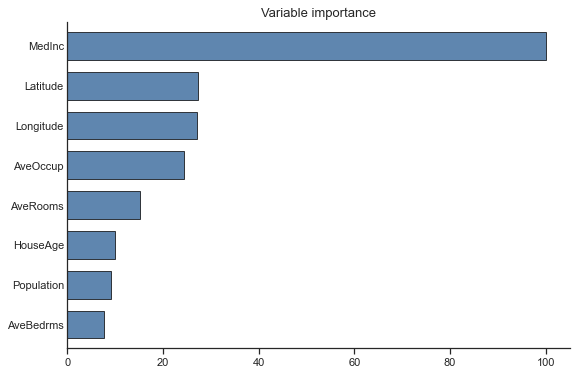

In [12]:
plot_feature_importance(gb, predictors)
plt.show()

Recent versions of scikit-learn introduced the [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) class, a histogram-based implementation of boosting inspired by LightGBM.  This implementation is significantly faster than `GradientBoostingRegressor` for large datasets.

The available hyperparameters are a bit different for `HistGradientBoostingRegressor`, see the documentation for details.

In [13]:
%%time

from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(learning_rate = 0.01, max_depth = 8, max_iter = 1901)
hgb.fit(X_train, y_train)

Wall time: 13 s


HistGradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_iter=1901)

## 3.2 XGBoost (Scikit-Learn API)

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a state-of-art gradient boosting library that is very popular among data scientist and [Kaggle](https://www.kaggle.com/) users. 

The easiest way to get started with XGBoost is to use the [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) provided by the package. The syntax is similar to the one before, except that we call the [XGBRegressor](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) class from the XGBoost package. 

XGBoost has significantly more [hyperparameters and options](https://xgboost.readthedocs.io/en/latest/parameter.html) than the scikit-learn implementations of boosting. The code shows the hyperparameters and settings that are most commonly adjusted.

In [14]:
%%time

import xgboost as xgb

xgbst = xgb.XGBRegressor(objective='reg:squarederror', booster = 'gbtree', learning_rate = 0.02, 
                        max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0, 
                        reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0)

# n_estimators: number of trees
# subsample: fraction of observations used to fit each tree
# reg_lambda: L2 regularisation penalty
# reg_alpha: L1 regularisation penalty
# colsample_bytree: fraction of features considered for each tree (alternatives: bylevel, bynode)
# min_child_weight: approximately equal to the minimum number of samples in each node

xgbst.fit(X_train, y_train)

Wall time: 5.93 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=6,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=1822, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

Other useful features supported by this API include: 

* Early stopping (we'll cover this below in the context of LightGBM).

* Pruning (the `gamma` parameter is a penalty for the number of leaves).
                  
* Mononicity constraints.

* Interaction contraints.

* GPU training.

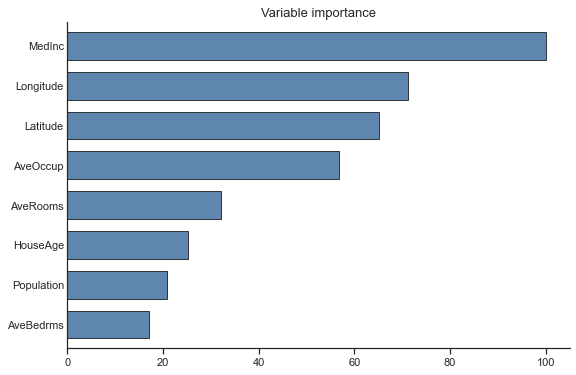

In [15]:
plot_feature_importance(xgbst, labels=predictors)
plt.show()

## 3.3 LightGBM (Scikit-Learn API)

[LightGBM](http://lightgbm.readthedocs.io/en/latest/index.html) is a gradient boosting library developed by Microsoft. Similarly to XGBoost, it has a [scikit-learn API](http://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api) that makes it simple to use. Conveniently, the implementation is very computationally efficient. 

Like XGBoost, LightGBM has a [large number](https://lightgbm.readthedocs.io/en/latest/Parameters.html) of configuration options. The code highlights the most important parameters to pay attention to.

Because of the way LightGBM [works](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc), we set the number of leaves rather than the maximum tree depth as in XGBoost. 

In [16]:
%%time

import lightgbm as lgb

lgbm = lgb.LGBMRegressor('learning_rate': 0.4,
                         'max_depth': 15,
                         'num_leaves': 20,
                         'feature_fraction': 0.8,
                         'subsample': 0.2, 
                         'objective': 'binary', 
                         'metric': 'auc',
                         'is_unbalance': True,
                         'boosting': 'gbdt',
                         'num_boost_round': 300,
                         'early_stopping_rounds': 30)

lgbm = lgbm.fit(X_train, y_train)

Wall time: 2.62 s


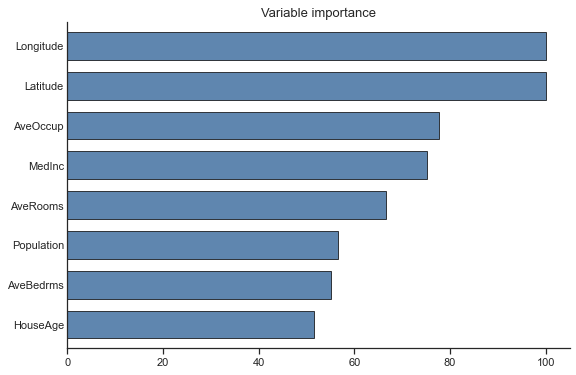

In [17]:
plot_feature_importance(lgbm, labels=predictors)
plt.show()

## 3.4 CatBoost

[CatBoost](https://catboost.ai/) is another important gradient boosting library. The main advantages of CatBoost is its great support for categorical features and computational speed. 

We use the [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) class, which works like a scikit-learn estimator. See the [documentation](https://catboost.ai/en/docs/references/training-parameters/) for the full list of parameters. 

The following cell is just to illustrate the syntax.

In [18]:
%%time

from catboost import CatBoostRegressor

cb = CatBoostRegressor(loss_function='RMSE', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0)
        
cb.fit(X_train, y_train)

# Important! If there were categorical features, you'd want to change the code to
# cb.fit(X_train, y_train, cat_features = cat_indices)
# where cat_indices is a one-dimensional array of indices indicating the categorical columns in X_train

Wall time: 4.56 s


The CatBoost [website](https://catboost.ai/) claims that the package provides great result with default parameters. Let's put this to test.

In [19]:
cb = CatBoostRegressor(loss_function='RMSE', verbose=0)        
cb.fit(X_train, y_train)

# 4. LightGBM: a deeper dive

LightGBM, XGBoost, and CatBoost are extremely useful libraries at the forefront of current machine learning practice. Therefore, you should try to learn at least one of these three packages as deeply as you can.

Because we only have time for one, we'll cover LightGBM. However, XGBoost and CatBoost are just as good. Either of the three may perform best for a given problem.

## 4.1 Training API 

We now use switch to native API, which is faster and worth learning. First, we need to convert the dataset into the LightGBM format. The LightGBM format is optimised for the learning algorithm and consumes less memory, which is important if you're working with large datasets.

In [20]:
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference = train_data)

# An important detail that is not applicable to this tutorial is that LightGBM can handle
# categorical features in a specialised way, without the need for prior encoding.

# Suppose that that the first two columns of X_train are categorical. You'd then run:
# train_data = lgb.Dataset(X_train, y_train, categorical_feature = [0, 1])

# Alternatively, you can pass the list of categorical features to the train function below

To train the model, we create a dictionary with the hyperparameters and settings and pass it the train function. As an additional detail, we also pass the validation set for evaluation. 

See the [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html#) for the full list of parameters. 

In [21]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'l2',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20, 
}

evals = {} 

lgbm = lgb.train(params, train_data, num_boost_round = 2000, valid_sets = [train_data, valid_data], 
                 valid_names=['Training', 'Validation'], evals_result = evals)

[1]	Training's l2: 0.317318	Validation's l2: 0.320224
[2]	Training's l2: 0.313098	Validation's l2: 0.316132
[3]	Training's l2: 0.30923	Validation's l2: 0.312389
[4]	Training's l2: 0.305153	Validation's l2: 0.30847
[5]	Training's l2: 0.301422	Validation's l2: 0.304859
[6]	Training's l2: 0.297612	Validation's l2: 0.301232
[7]	Training's l2: 0.293826	Validation's l2: 0.297592
[8]	Training's l2: 0.290236	Validation's l2: 0.294112
[9]	Training's l2: 0.286551	Validation's l2: 0.290553
[10]	Training's l2: 0.282987	Validation's l2: 0.287143
[11]	Training's l2: 0.279448	Validation's l2: 0.283715
[12]	Training's l2: 0.276059	Validation's l2: 0.280486
[13]	Training's l2: 0.272678	Validation's l2: 0.277177
[14]	Training's l2: 0.269376	Validation's l2: 0.27397
[15]	Training's l2: 0.265768	Validation's l2: 0.270445
[16]	Training's l2: 0.26262	Validation's l2: 0.2674
[17]	Training's l2: 0.259457	Validation's l2: 0.264351
[18]	Training's l2: 0.256356	Validation's l2: 0.261363
[19]	Training's l2: 0.253

[219]	Training's l2: 0.0622402	Validation's l2: 0.0762804
[220]	Training's l2: 0.0619758	Validation's l2: 0.0760239
[221]	Training's l2: 0.0618213	Validation's l2: 0.0759266
[222]	Training's l2: 0.0616658	Validation's l2: 0.075812
[223]	Training's l2: 0.0615163	Validation's l2: 0.0757191
[224]	Training's l2: 0.0612399	Validation's l2: 0.0754536
[225]	Training's l2: 0.0610828	Validation's l2: 0.0753455
[226]	Training's l2: 0.0608665	Validation's l2: 0.0751489
[227]	Training's l2: 0.0606238	Validation's l2: 0.0749342
[228]	Training's l2: 0.0604715	Validation's l2: 0.0748185
[229]	Training's l2: 0.0602351	Validation's l2: 0.0746086
[230]	Training's l2: 0.0600325	Validation's l2: 0.0744229
[231]	Training's l2: 0.0598616	Validation's l2: 0.0742917
[232]	Training's l2: 0.0597016	Validation's l2: 0.0741624
[233]	Training's l2: 0.0595406	Validation's l2: 0.0740309
[234]	Training's l2: 0.0593966	Validation's l2: 0.073922
[235]	Training's l2: 0.0592656	Validation's l2: 0.073832
[236]	Training's 

[373]	Training's l2: 0.0435584	Validation's l2: 0.0617144
[374]	Training's l2: 0.0434902	Validation's l2: 0.061674
[375]	Training's l2: 0.0434135	Validation's l2: 0.0616183
[376]	Training's l2: 0.043319	Validation's l2: 0.0615445
[377]	Training's l2: 0.043229	Validation's l2: 0.0614718
[378]	Training's l2: 0.0431581	Validation's l2: 0.0614264
[379]	Training's l2: 0.0430662	Validation's l2: 0.0613524
[380]	Training's l2: 0.042995	Validation's l2: 0.0613038
[381]	Training's l2: 0.0429051	Validation's l2: 0.0612343
[382]	Training's l2: 0.0428479	Validation's l2: 0.0612085
[383]	Training's l2: 0.0427918	Validation's l2: 0.0611835
[384]	Training's l2: 0.0427163	Validation's l2: 0.0611202
[385]	Training's l2: 0.0426309	Validation's l2: 0.0610454
[386]	Training's l2: 0.0425569	Validation's l2: 0.0609844
[387]	Training's l2: 0.0424827	Validation's l2: 0.0609265
[388]	Training's l2: 0.0424299	Validation's l2: 0.0609104
[389]	Training's l2: 0.0423784	Validation's l2: 0.0608949
[390]	Training's l

[535]	Training's l2: 0.0353105	Validation's l2: 0.0571615
[536]	Training's l2: 0.0352748	Validation's l2: 0.0571548
[537]	Training's l2: 0.035243	Validation's l2: 0.0571447
[538]	Training's l2: 0.0352077	Validation's l2: 0.0571371
[539]	Training's l2: 0.0351695	Validation's l2: 0.0571234
[540]	Training's l2: 0.0351337	Validation's l2: 0.0571148
[541]	Training's l2: 0.0351038	Validation's l2: 0.0571141
[542]	Training's l2: 0.035076	Validation's l2: 0.0571086
[543]	Training's l2: 0.0350399	Validation's l2: 0.0570856
[544]	Training's l2: 0.0349961	Validation's l2: 0.0570595
[545]	Training's l2: 0.0349645	Validation's l2: 0.0570433
[546]	Training's l2: 0.0349316	Validation's l2: 0.0570305
[547]	Training's l2: 0.0348944	Validation's l2: 0.0570238
[548]	Training's l2: 0.0348531	Validation's l2: 0.0570066
[549]	Training's l2: 0.034821	Validation's l2: 0.0569948
[550]	Training's l2: 0.0347863	Validation's l2: 0.0569868
[551]	Training's l2: 0.0347556	Validation's l2: 0.0569811
[552]	Training's 

[736]	Training's l2: 0.0292655	Validation's l2: 0.0552485
[737]	Training's l2: 0.029242	Validation's l2: 0.0552382
[738]	Training's l2: 0.0292231	Validation's l2: 0.0552369
[739]	Training's l2: 0.0292001	Validation's l2: 0.0552271
[740]	Training's l2: 0.0291769	Validation's l2: 0.0552166
[741]	Training's l2: 0.029151	Validation's l2: 0.055213
[742]	Training's l2: 0.0291268	Validation's l2: 0.0552073
[743]	Training's l2: 0.0291007	Validation's l2: 0.0552082
[744]	Training's l2: 0.0290744	Validation's l2: 0.0552089
[745]	Training's l2: 0.0290493	Validation's l2: 0.0552011
[746]	Training's l2: 0.0290216	Validation's l2: 0.0551948
[747]	Training's l2: 0.0290006	Validation's l2: 0.0551849
[748]	Training's l2: 0.0289739	Validation's l2: 0.055176
[749]	Training's l2: 0.0289471	Validation's l2: 0.0551697
[750]	Training's l2: 0.0289209	Validation's l2: 0.0551645
[751]	Training's l2: 0.0288945	Validation's l2: 0.0551611
[752]	Training's l2: 0.0288734	Validation's l2: 0.0551601
[753]	Training's l

[940]	Training's l2: 0.0250656	Validation's l2: 0.0542921
[941]	Training's l2: 0.0250458	Validation's l2: 0.0542886
[942]	Training's l2: 0.0250264	Validation's l2: 0.0542784
[943]	Training's l2: 0.0250075	Validation's l2: 0.05427
[944]	Training's l2: 0.0249916	Validation's l2: 0.0542669
[945]	Training's l2: 0.0249728	Validation's l2: 0.0542671
[946]	Training's l2: 0.0249529	Validation's l2: 0.0542655
[947]	Training's l2: 0.0249353	Validation's l2: 0.0542639
[948]	Training's l2: 0.0249162	Validation's l2: 0.0542604
[949]	Training's l2: 0.0248944	Validation's l2: 0.0542508
[950]	Training's l2: 0.0248747	Validation's l2: 0.0542443
[951]	Training's l2: 0.0248529	Validation's l2: 0.0542276
[952]	Training's l2: 0.0248362	Validation's l2: 0.0542219
[953]	Training's l2: 0.0248217	Validation's l2: 0.0542188
[954]	Training's l2: 0.0248048	Validation's l2: 0.0542195
[955]	Training's l2: 0.0247885	Validation's l2: 0.0542115
[956]	Training's l2: 0.024765	Validation's l2: 0.0542019
[957]	Training's 

[1154]	Training's l2: 0.0216577	Validation's l2: 0.0536475
[1155]	Training's l2: 0.0216419	Validation's l2: 0.0536445
[1156]	Training's l2: 0.0216295	Validation's l2: 0.053641
[1157]	Training's l2: 0.0216172	Validation's l2: 0.0536404
[1158]	Training's l2: 0.0216038	Validation's l2: 0.0536391
[1159]	Training's l2: 0.0215904	Validation's l2: 0.0536328
[1160]	Training's l2: 0.0215784	Validation's l2: 0.0536296
[1161]	Training's l2: 0.0215619	Validation's l2: 0.0536321
[1162]	Training's l2: 0.0215468	Validation's l2: 0.0536283
[1163]	Training's l2: 0.0215308	Validation's l2: 0.0536277
[1164]	Training's l2: 0.021517	Validation's l2: 0.0536271
[1165]	Training's l2: 0.0215045	Validation's l2: 0.0536257
[1166]	Training's l2: 0.0214907	Validation's l2: 0.0536249
[1167]	Training's l2: 0.0214792	Validation's l2: 0.0536242
[1168]	Training's l2: 0.0214674	Validation's l2: 0.0536222
[1169]	Training's l2: 0.0214541	Validation's l2: 0.0536217
[1170]	Training's l2: 0.0214429	Validation's l2: 0.05362
[

[1375]	Training's l2: 0.0189096	Validation's l2: 0.0532194
[1376]	Training's l2: 0.0188994	Validation's l2: 0.0532175
[1377]	Training's l2: 0.0188863	Validation's l2: 0.0532152
[1378]	Training's l2: 0.018877	Validation's l2: 0.0532112
[1379]	Training's l2: 0.0188658	Validation's l2: 0.053206
[1380]	Training's l2: 0.0188573	Validation's l2: 0.0532033
[1381]	Training's l2: 0.0188466	Validation's l2: 0.0531986
[1382]	Training's l2: 0.0188348	Validation's l2: 0.0531957
[1383]	Training's l2: 0.0188242	Validation's l2: 0.0531956
[1384]	Training's l2: 0.0188134	Validation's l2: 0.0531916
[1385]	Training's l2: 0.0188023	Validation's l2: 0.0531884
[1386]	Training's l2: 0.0187917	Validation's l2: 0.0531883
[1387]	Training's l2: 0.0187801	Validation's l2: 0.053189
[1388]	Training's l2: 0.0187688	Validation's l2: 0.0531864
[1389]	Training's l2: 0.0187585	Validation's l2: 0.0531869
[1390]	Training's l2: 0.0187475	Validation's l2: 0.0531845
[1391]	Training's l2: 0.0187379	Validation's l2: 0.0531834


[1591]	Training's l2: 0.0166682	Validation's l2: 0.05298
[1592]	Training's l2: 0.0166581	Validation's l2: 0.0529753
[1593]	Training's l2: 0.0166489	Validation's l2: 0.0529755
[1594]	Training's l2: 0.0166389	Validation's l2: 0.0529707
[1595]	Training's l2: 0.0166299	Validation's l2: 0.0529698
[1596]	Training's l2: 0.0166215	Validation's l2: 0.0529706
[1597]	Training's l2: 0.0166135	Validation's l2: 0.052971
[1598]	Training's l2: 0.0166049	Validation's l2: 0.0529717
[1599]	Training's l2: 0.0165974	Validation's l2: 0.0529719
[1600]	Training's l2: 0.0165884	Validation's l2: 0.0529704
[1601]	Training's l2: 0.0165767	Validation's l2: 0.0529677
[1602]	Training's l2: 0.0165661	Validation's l2: 0.0529656
[1603]	Training's l2: 0.0165568	Validation's l2: 0.0529663
[1604]	Training's l2: 0.0165485	Validation's l2: 0.0529647
[1605]	Training's l2: 0.0165383	Validation's l2: 0.0529626
[1606]	Training's l2: 0.01653	Validation's l2: 0.0529599
[1607]	Training's l2: 0.0165213	Validation's l2: 0.0529591
[1

[1789]	Training's l2: 0.0149432	Validation's l2: 0.0528395
[1790]	Training's l2: 0.0149323	Validation's l2: 0.0528374
[1791]	Training's l2: 0.014923	Validation's l2: 0.0528362
[1792]	Training's l2: 0.0149127	Validation's l2: 0.0528317
[1793]	Training's l2: 0.0149062	Validation's l2: 0.0528311
[1794]	Training's l2: 0.0148966	Validation's l2: 0.0528308
[1795]	Training's l2: 0.0148879	Validation's l2: 0.052829
[1796]	Training's l2: 0.0148802	Validation's l2: 0.0528281
[1797]	Training's l2: 0.0148733	Validation's l2: 0.0528275
[1798]	Training's l2: 0.0148657	Validation's l2: 0.0528255
[1799]	Training's l2: 0.0148566	Validation's l2: 0.0528243
[1800]	Training's l2: 0.0148498	Validation's l2: 0.0528238
[1801]	Training's l2: 0.0148403	Validation's l2: 0.0528196
[1802]	Training's l2: 0.0148328	Validation's l2: 0.0528179
[1803]	Training's l2: 0.0148269	Validation's l2: 0.052818
[1804]	Training's l2: 0.0148197	Validation's l2: 0.0528163
[1805]	Training's l2: 0.0148105	Validation's l2: 0.0528156


[1980]	Training's l2: 0.0134723	Validation's l2: 0.0527058
[1981]	Training's l2: 0.0134638	Validation's l2: 0.0527021
[1982]	Training's l2: 0.0134565	Validation's l2: 0.0526992
[1983]	Training's l2: 0.0134484	Validation's l2: 0.0526967
[1984]	Training's l2: 0.0134418	Validation's l2: 0.0526966
[1985]	Training's l2: 0.013435	Validation's l2: 0.0526985
[1986]	Training's l2: 0.0134273	Validation's l2: 0.0526997
[1987]	Training's l2: 0.0134207	Validation's l2: 0.0527004
[1988]	Training's l2: 0.0134137	Validation's l2: 0.0526987
[1989]	Training's l2: 0.0134047	Validation's l2: 0.0526982
[1990]	Training's l2: 0.0133977	Validation's l2: 0.0526978
[1991]	Training's l2: 0.0133913	Validation's l2: 0.0526999
[1992]	Training's l2: 0.013385	Validation's l2: 0.0527021
[1993]	Training's l2: 0.0133789	Validation's l2: 0.0527036
[1994]	Training's l2: 0.0133727	Validation's l2: 0.0527054
[1995]	Training's l2: 0.0133675	Validation's l2: 0.0527065
[1996]	Training's l2: 0.0133614	Validation's l2: 0.0527076

The `plot_metric` function allows you to plot the training and validation errors against the number of trees. Fortunately, boosting is slow to overfit.

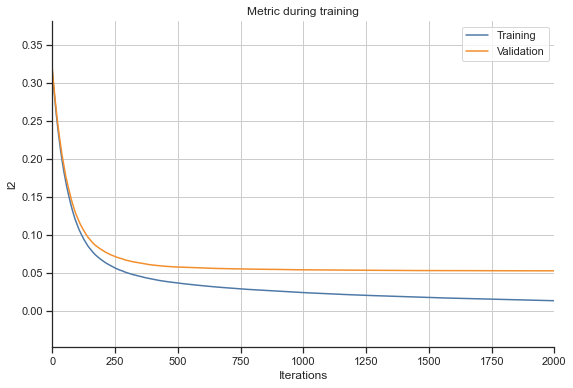

In [22]:
lgb.plot_metric(evals, metric = 'l2')
sns.despine()
plt.show()

## 4.2 Early stopping 

In the following example, we activate early stopping by setting the `early_stopping_rounds` parameter. In this case, LightGBM will stop training when the validation scores don't improve for 50 iterations. 

In [23]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20,
}

evals = {} 

lgbm = lgb.train(params, train_data, num_boost_round = 5000,  valid_sets = [train_data, valid_data], 
                 valid_names=['Training', 'Validation'], early_stopping_rounds = 100,  evals_result = evals)

[1]	Training's l2: 0.317318	Validation's l2: 0.320224
Training until validation scores don't improve for 100 rounds
[2]	Training's l2: 0.313098	Validation's l2: 0.316132
[3]	Training's l2: 0.30923	Validation's l2: 0.312389
[4]	Training's l2: 0.305153	Validation's l2: 0.30847
[5]	Training's l2: 0.301422	Validation's l2: 0.304859
[6]	Training's l2: 0.297612	Validation's l2: 0.301232
[7]	Training's l2: 0.293826	Validation's l2: 0.297592
[8]	Training's l2: 0.290236	Validation's l2: 0.294112
[9]	Training's l2: 0.286551	Validation's l2: 0.290553
[10]	Training's l2: 0.282987	Validation's l2: 0.287143
[11]	Training's l2: 0.279448	Validation's l2: 0.283715
[12]	Training's l2: 0.276059	Validation's l2: 0.280486
[13]	Training's l2: 0.272678	Validation's l2: 0.277177
[14]	Training's l2: 0.269376	Validation's l2: 0.27397
[15]	Training's l2: 0.265768	Validation's l2: 0.270445
[16]	Training's l2: 0.26262	Validation's l2: 0.2674
[17]	Training's l2: 0.259457	Validation's l2: 0.264351
[18]	Training's l2

[229]	Training's l2: 0.0602351	Validation's l2: 0.0746086
[230]	Training's l2: 0.0600325	Validation's l2: 0.0744229
[231]	Training's l2: 0.0598616	Validation's l2: 0.0742917
[232]	Training's l2: 0.0597016	Validation's l2: 0.0741624
[233]	Training's l2: 0.0595406	Validation's l2: 0.0740309
[234]	Training's l2: 0.0593966	Validation's l2: 0.073922
[235]	Training's l2: 0.0592656	Validation's l2: 0.073832
[236]	Training's l2: 0.0590885	Validation's l2: 0.0736763
[237]	Training's l2: 0.0589548	Validation's l2: 0.0735785
[238]	Training's l2: 0.0587955	Validation's l2: 0.0734562
[239]	Training's l2: 0.058623	Validation's l2: 0.0733188
[240]	Training's l2: 0.0584511	Validation's l2: 0.0731831
[241]	Training's l2: 0.0582806	Validation's l2: 0.0730327
[242]	Training's l2: 0.0580718	Validation's l2: 0.0728385
[243]	Training's l2: 0.0578748	Validation's l2: 0.0726599
[244]	Training's l2: 0.0577422	Validation's l2: 0.0725713
[245]	Training's l2: 0.0575805	Validation's l2: 0.0724315
[246]	Training's 

[419]	Training's l2: 0.0404845	Validation's l2: 0.0597097
[420]	Training's l2: 0.0404206	Validation's l2: 0.0596647
[421]	Training's l2: 0.0403631	Validation's l2: 0.0596184
[422]	Training's l2: 0.0403052	Validation's l2: 0.059581
[423]	Training's l2: 0.040246	Validation's l2: 0.0595494
[424]	Training's l2: 0.040202	Validation's l2: 0.0595359
[425]	Training's l2: 0.04015	Validation's l2: 0.0595107
[426]	Training's l2: 0.0400967	Validation's l2: 0.059476
[427]	Training's l2: 0.0400536	Validation's l2: 0.0594622
[428]	Training's l2: 0.0399984	Validation's l2: 0.0594174
[429]	Training's l2: 0.0399456	Validation's l2: 0.0593736
[430]	Training's l2: 0.0399007	Validation's l2: 0.059342
[431]	Training's l2: 0.0398525	Validation's l2: 0.0593146
[432]	Training's l2: 0.0398024	Validation's l2: 0.0592946
[433]	Training's l2: 0.0397531	Validation's l2: 0.0592681
[434]	Training's l2: 0.0397127	Validation's l2: 0.0592426
[435]	Training's l2: 0.0396615	Validation's l2: 0.0592161
[436]	Training's l2: 

[620]	Training's l2: 0.0324133	Validation's l2: 0.0561332
[621]	Training's l2: 0.0323821	Validation's l2: 0.0561198
[622]	Training's l2: 0.0323524	Validation's l2: 0.0561075
[623]	Training's l2: 0.032323	Validation's l2: 0.0560945
[624]	Training's l2: 0.0322979	Validation's l2: 0.0560947
[625]	Training's l2: 0.0322748	Validation's l2: 0.0560949
[626]	Training's l2: 0.0322443	Validation's l2: 0.0560767
[627]	Training's l2: 0.0322124	Validation's l2: 0.0560581
[628]	Training's l2: 0.0321809	Validation's l2: 0.0560409
[629]	Training's l2: 0.0321503	Validation's l2: 0.0560262
[630]	Training's l2: 0.0321196	Validation's l2: 0.0560105
[631]	Training's l2: 0.0320879	Validation's l2: 0.0560003
[632]	Training's l2: 0.0320603	Validation's l2: 0.0559917
[633]	Training's l2: 0.0320331	Validation's l2: 0.0559872
[634]	Training's l2: 0.0320038	Validation's l2: 0.055978
[635]	Training's l2: 0.0319751	Validation's l2: 0.0559723
[636]	Training's l2: 0.0319426	Validation's l2: 0.055962
[637]	Training's 

[832]	Training's l2: 0.0271617	Validation's l2: 0.0547867
[833]	Training's l2: 0.0271379	Validation's l2: 0.0547757
[834]	Training's l2: 0.0271182	Validation's l2: 0.0547697
[835]	Training's l2: 0.0270942	Validation's l2: 0.0547586
[836]	Training's l2: 0.0270727	Validation's l2: 0.0547529
[837]	Training's l2: 0.0270521	Validation's l2: 0.0547479
[838]	Training's l2: 0.0270294	Validation's l2: 0.0547391
[839]	Training's l2: 0.0270056	Validation's l2: 0.0547364
[840]	Training's l2: 0.0269869	Validation's l2: 0.0547286
[841]	Training's l2: 0.0269662	Validation's l2: 0.0547308
[842]	Training's l2: 0.0269436	Validation's l2: 0.0547219
[843]	Training's l2: 0.0269197	Validation's l2: 0.0547171
[844]	Training's l2: 0.026898	Validation's l2: 0.0547154
[845]	Training's l2: 0.026878	Validation's l2: 0.0547168
[846]	Training's l2: 0.0268589	Validation's l2: 0.0547128
[847]	Training's l2: 0.0268398	Validation's l2: 0.0547112
[848]	Training's l2: 0.0268202	Validation's l2: 0.0547089
[849]	Training's

[1048]	Training's l2: 0.0232484	Validation's l2: 0.0539319
[1049]	Training's l2: 0.0232348	Validation's l2: 0.0539279
[1050]	Training's l2: 0.0232168	Validation's l2: 0.0539267
[1051]	Training's l2: 0.0232004	Validation's l2: 0.0539259
[1052]	Training's l2: 0.0231871	Validation's l2: 0.0539229
[1053]	Training's l2: 0.0231705	Validation's l2: 0.053917
[1054]	Training's l2: 0.0231575	Validation's l2: 0.0539153
[1055]	Training's l2: 0.0231442	Validation's l2: 0.0539122
[1056]	Training's l2: 0.0231307	Validation's l2: 0.053912
[1057]	Training's l2: 0.0231181	Validation's l2: 0.0539104
[1058]	Training's l2: 0.0230995	Validation's l2: 0.053912
[1059]	Training's l2: 0.0230814	Validation's l2: 0.0539158
[1060]	Training's l2: 0.0230659	Validation's l2: 0.0539129
[1061]	Training's l2: 0.0230486	Validation's l2: 0.0539098
[1062]	Training's l2: 0.0230313	Validation's l2: 0.0539068
[1063]	Training's l2: 0.0230177	Validation's l2: 0.0539038
[1064]	Training's l2: 0.0230006	Validation's l2: 0.0538978


[1269]	Training's l2: 0.0201835	Validation's l2: 0.0534172
[1270]	Training's l2: 0.0201696	Validation's l2: 0.0534129
[1271]	Training's l2: 0.0201559	Validation's l2: 0.0534102
[1272]	Training's l2: 0.0201438	Validation's l2: 0.0534093
[1273]	Training's l2: 0.0201303	Validation's l2: 0.0534077
[1274]	Training's l2: 0.0201189	Validation's l2: 0.0534064
[1275]	Training's l2: 0.0201079	Validation's l2: 0.0534065
[1276]	Training's l2: 0.0200987	Validation's l2: 0.0534051
[1277]	Training's l2: 0.0200863	Validation's l2: 0.0534062
[1278]	Training's l2: 0.0200736	Validation's l2: 0.053403
[1279]	Training's l2: 0.0200614	Validation's l2: 0.053405
[1280]	Training's l2: 0.0200498	Validation's l2: 0.053407
[1281]	Training's l2: 0.0200384	Validation's l2: 0.0534123
[1282]	Training's l2: 0.0200267	Validation's l2: 0.0534106
[1283]	Training's l2: 0.0200141	Validation's l2: 0.0534068
[1284]	Training's l2: 0.0200013	Validation's l2: 0.0534044
[1285]	Training's l2: 0.0199898	Validation's l2: 0.0534063


[1483]	Training's l2: 0.017748	Validation's l2: 0.0530599
[1484]	Training's l2: 0.0177381	Validation's l2: 0.0530596
[1485]	Training's l2: 0.0177271	Validation's l2: 0.0530635
[1486]	Training's l2: 0.0177189	Validation's l2: 0.0530646
[1487]	Training's l2: 0.0177054	Validation's l2: 0.0530585
[1488]	Training's l2: 0.0176917	Validation's l2: 0.053056
[1489]	Training's l2: 0.0176786	Validation's l2: 0.0530507
[1490]	Training's l2: 0.0176661	Validation's l2: 0.05305
[1491]	Training's l2: 0.0176566	Validation's l2: 0.0530451
[1492]	Training's l2: 0.0176478	Validation's l2: 0.0530453
[1493]	Training's l2: 0.0176369	Validation's l2: 0.0530425
[1494]	Training's l2: 0.0176276	Validation's l2: 0.053041
[1495]	Training's l2: 0.017619	Validation's l2: 0.053037
[1496]	Training's l2: 0.0176095	Validation's l2: 0.0530399
[1497]	Training's l2: 0.0176007	Validation's l2: 0.0530415
[1498]	Training's l2: 0.0175912	Validation's l2: 0.0530435
[1499]	Training's l2: 0.0175826	Validation's l2: 0.0530463
[150

[1675]	Training's l2: 0.0159013	Validation's l2: 0.0529096
[1676]	Training's l2: 0.0158947	Validation's l2: 0.05291
[1677]	Training's l2: 0.0158866	Validation's l2: 0.0529093
[1678]	Training's l2: 0.015879	Validation's l2: 0.0529081
[1679]	Training's l2: 0.0158708	Validation's l2: 0.0529091
[1680]	Training's l2: 0.0158639	Validation's l2: 0.0529088
[1681]	Training's l2: 0.0158546	Validation's l2: 0.0529027
[1682]	Training's l2: 0.0158463	Validation's l2: 0.0528971
[1683]	Training's l2: 0.0158382	Validation's l2: 0.0528917
[1684]	Training's l2: 0.0158291	Validation's l2: 0.0528891
[1685]	Training's l2: 0.0158176	Validation's l2: 0.0528809
[1686]	Training's l2: 0.0158077	Validation's l2: 0.0528819
[1687]	Training's l2: 0.0157978	Validation's l2: 0.0528809
[1688]	Training's l2: 0.0157893	Validation's l2: 0.0528794
[1689]	Training's l2: 0.0157799	Validation's l2: 0.0528759
[1690]	Training's l2: 0.0157707	Validation's l2: 0.0528725
[1691]	Training's l2: 0.0157632	Validation's l2: 0.0528721


[1864]	Training's l2: 0.01434	Validation's l2: 0.0527673
[1865]	Training's l2: 0.0143312	Validation's l2: 0.0527668
[1866]	Training's l2: 0.0143245	Validation's l2: 0.0527677
[1867]	Training's l2: 0.0143166	Validation's l2: 0.0527677
[1868]	Training's l2: 0.0143095	Validation's l2: 0.0527679
[1869]	Training's l2: 0.0143026	Validation's l2: 0.0527681
[1870]	Training's l2: 0.0142958	Validation's l2: 0.0527674
[1871]	Training's l2: 0.0142889	Validation's l2: 0.0527678
[1872]	Training's l2: 0.0142833	Validation's l2: 0.0527669
[1873]	Training's l2: 0.0142745	Validation's l2: 0.0527605
[1874]	Training's l2: 0.014266	Validation's l2: 0.0527608
[1875]	Training's l2: 0.0142594	Validation's l2: 0.0527614
[1876]	Training's l2: 0.0142531	Validation's l2: 0.0527623
[1877]	Training's l2: 0.0142463	Validation's l2: 0.0527611
[1878]	Training's l2: 0.0142373	Validation's l2: 0.0527592
[1879]	Training's l2: 0.0142284	Validation's l2: 0.0527574
[1880]	Training's l2: 0.014222	Validation's l2: 0.0527568
[

[2086]	Training's l2: 0.0127632	Validation's l2: 0.0526777
[2087]	Training's l2: 0.0127566	Validation's l2: 0.0526781
[2088]	Training's l2: 0.0127504	Validation's l2: 0.0526789
[2089]	Training's l2: 0.0127443	Validation's l2: 0.0526797
[2090]	Training's l2: 0.0127382	Validation's l2: 0.0526792
[2091]	Training's l2: 0.012733	Validation's l2: 0.0526794
[2092]	Training's l2: 0.0127253	Validation's l2: 0.0526797
[2093]	Training's l2: 0.0127187	Validation's l2: 0.0526794
[2094]	Training's l2: 0.0127111	Validation's l2: 0.0526806
[2095]	Training's l2: 0.012704	Validation's l2: 0.05268
[2096]	Training's l2: 0.0126972	Validation's l2: 0.052679
[2097]	Training's l2: 0.012689	Validation's l2: 0.0526802
[2098]	Training's l2: 0.0126816	Validation's l2: 0.0526807
[2099]	Training's l2: 0.0126749	Validation's l2: 0.0526816
[2100]	Training's l2: 0.01267	Validation's l2: 0.0526801
[2101]	Training's l2: 0.0126629	Validation's l2: 0.0526803
[2102]	Training's l2: 0.0126562	Validation's l2: 0.05268
[2103]	

Wall time: 4.49 s


## 4.3 Cross-validation

The [cv](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html) performs cross-validation. The early stopping functionality is useful for selecting the best number of boosting iterations. 

In [24]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'num_iterations': 5000,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20, 
}

evals = {} 

history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 100)

Wall time: 13.3 s


The `cv` function returns a dictionary with the requested CV metrics computed for each boosting iterations. The last entry is the one for the best iteration when using early stopping. 

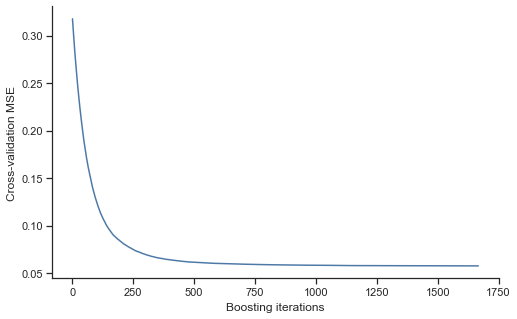

In [25]:
fig, ax = plt.subplots(figsize=(8,5))

plt.plot(history['l2-mean'])

ax.set_ylabel('Cross-validation MSE')
ax.set_xlabel('Boosting iterations')

sns.despine()
plt.show()

## 4.4 Hyperparameter optimisation

Hyperparameter optimisation is one of the most difficult aspects of boosting, as we have many hyperparameters to select.

In general, it's useful to keep the learning rate fixed for hyperparameter optimisation. Smaller learning rates tend to improve performance, but increase the required number of trees and the computational cost. Therefore, we choose the learning rate according to the computational budget. It's common to set a higher learning rate to speed up hyperparameter optimisation and reduce it later to fit the final version of the model.

The next cell implements a general approach for optimising the hyperparameters, taking advantage of early stopping. 

In [26]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05, 
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
     }
    
    # Cross-validation 
    history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 50)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['l2-mean']))
    
    return history['l2-mean'][-1] # returns CV error for the best trial

sampler = TPESampler(seed = 42) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=500, timeout = 120)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2021-10-13 12:50:25,973] A new study created in memory with name: no-name-41f943f9-4579-44b3-9c3e-1939222d37a6
[I 2021-10-13 12:50:31,846] Trial 0 finished with value: 0.05965452373945137 and parameters: {'num_leaves': 25, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.5779972601681014, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.05965452373945137.
[I 2021-10-13 12:50:34,127] Trial 1 finished with value: 0.0619654177553413 and parameters: {'num_leaves': 56, 'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682, 'bagging_fraction': 0.5102922471479012, 'bagging_freq': 10, 'feature_fraction': 0.9162213204002109, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.05965452373945137.
[I 2021-10-13 12:50:36,129] Trial 2 finished with value: 0.06197645636651024 and parameters: {'num_leaves': 13, 'lambda_l1': 4.4734294104626844e-07, 'lambda_l2': 5.472429642032198

[I 2021-10-13 12:51:32,119] Trial 22 finished with value: 0.060364356276876176 and parameters: {'num_leaves': 29, 'lambda_l1': 2.296515046942908e-05, 'lambda_l2': 3.254994145707445e-07, 'bagging_fraction': 0.7296111162012735, 'bagging_freq': 6, 'feature_fraction': 0.6631869814032979, 'min_data_in_leaf': 18}. Best is trial 18 with value: 0.058452979729703224.
[I 2021-10-13 12:51:34,412] Trial 23 finished with value: 0.060290464993980955 and parameters: {'num_leaves': 37, 'lambda_l1': 0.001187537243249661, 'lambda_l2': 6.432891706891695e-07, 'bagging_fraction': 0.7711835167284172, 'bagging_freq': 4, 'feature_fraction': 0.6205070465045336, 'min_data_in_leaf': 47}. Best is trial 18 with value: 0.058452979729703224.
[I 2021-10-13 12:51:36,729] Trial 24 finished with value: 0.05817291422564534 and parameters: {'num_leaves': 29, 'lambda_l1': 0.014991464070641839, 'lambda_l2': 4.8915696219807387e-05, 'bagging_fraction': 0.6982414881840296, 'bagging_freq': 2, 'feature_fraction': 0.7694422309371

We can retrieve the best parameters as follows.

In [27]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 314 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'num_leaves': 49,
 'lambda_l1': 0.34448638726962943,
 'lambda_l2': 2.569881079449741e-06,
 'bagging_fraction': 0.7991987707634133,
 'bagging_freq': 8,
 'feature_fraction': 0.7922287095621835,
 'min_data_in_leaf': 11}

With some many hyperparameters, it's helpful to know which ones make the most difference for the quality of the model. The `get_param_importances` function from Optuna does exactly this.  

In [28]:
importance = optuna.importance.get_param_importances(study)

importance

OrderedDict([('min_data_in_leaf', 0.5919032056001015),
             ('bagging_freq', 0.10695505734580353),
             ('lambda_l1', 0.09490556266268717),
             ('num_leaves', 0.07990953681289918),
             ('feature_fraction', 0.07200954177662965),
             ('bagging_fraction', 0.03926167519325754),
             ('lambda_l2', 0.015055420608621464)])

Optuna also has a LightGBM integration with useful features. For example, we can modify the above code to prune unpromising trials.

In [29]:
from optuna.integration import LightGBMPruningCallback

def objective(trial):
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10.0), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10.0), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.3, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
     }
    
    # Instantiate pruning callback
    pruning_callback =  LightGBMPruningCallback(trial, 'l2')
    
    # LightGBM cross-validation
    history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 100,
                 callbacks = [pruning_callback])
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['l2-mean']))
    
    return history['l2-mean'][-1] # returns CV error for the best trial

# Instantiating the sampler to set the random seed
sampler = TPESampler(seed=42) 

# Instantiating the pruner
# The min_resource should be the minimum number of trees required to reasonably judge performance
# This can be tricky to get it right for boosting
# See the notes in the documentation:
# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html
pruner = optuna.pruners.HyperbandPruner(min_resource = 100, max_resource = 'auto', reduction_factor = 3)

# A simpler alternative is the median pruner
# This method prunes trials with partial performance below the median of previous trials 
#pruner = optuna.pruners.MedianPruner(n_startup_trials = 10, n_warmup_steps = 500, interval_steps = 5)

study = optuna.create_study(direction='minimize', sampler = sampler, pruner = pruner)
study.optimize(objective, n_trials=500, timeout= 120)

[I 2021-10-13 12:52:27,322] A new study created in memory with name: no-name-ae8f5953-56ef-46f1-a3a7-8dba7d420a1a
[I 2021-10-13 12:52:33,990] Trial 0 finished with value: 0.0609082225412972 and parameters: {'num_leaves': 25, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.40919616423534183, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.0609082225412972.
[I 2021-10-13 12:52:36,790] Trial 1 finished with value: 0.0619654177553413 and parameters: {'num_leaves': 56, 'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682, 'bagging_fraction': 0.5102922471479012, 'bagging_freq': 10, 'feature_fraction': 0.8827098485602951, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.0609082225412972.
[I 2021-10-13 12:52:39,295] Trial 2 finished with value: 0.0650143078191778 and parameters: {'num_leaves': 13, 'lambda_l1': 4.4734294104626844e-07, 'lambda_l2': 5.472429642032198e-0

[I 2021-10-13 12:54:03,474] Trial 40 finished with value: 0.06062457996560414 and parameters: {'num_leaves': 50, 'lambda_l1': 1.4536813134532461e-08, 'lambda_l2': 2.829314516141267e-08, 'bagging_fraction': 0.9934591451423094, 'bagging_freq': 4, 'feature_fraction': 0.8649538261092407, 'min_data_in_leaf': 99}. Best is trial 37 with value: 0.058124406832177636.
[I 2021-10-13 12:54:06,260] Trial 41 pruned. Trial was pruned at iteration 300.
[I 2021-10-13 12:54:10,120] Trial 42 finished with value: 0.06335644905874736 and parameters: {'num_leaves': 17, 'lambda_l1': 6.885332382888648e-08, 'lambda_l2': 1.188343025435737, 'bagging_fraction': 0.9502090285816652, 'bagging_freq': 7, 'feature_fraction': 0.5373208537340904, 'min_data_in_leaf': 45}. Best is trial 37 with value: 0.058124406832177636.
[I 2021-10-13 12:54:11,024] Trial 43 pruned. Trial was pruned at iteration 100.
[I 2021-10-13 12:54:15,144] Trial 44 pruned. Trial was pruned at iteration 300.
[I 2021-10-13 12:54:16,305] Trial 45 pruned

Observe how pruning allowed Optuna to execute more trials within the allocated time. In practice, HyperBand needs [more trials](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html) to work well with TPE sampling. 

In [30]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 272 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'num_leaves': 38,
 'lambda_l1': 1.3517397175465322e-08,
 'lambda_l2': 4.124849612281494e-07,
 'bagging_fraction': 0.9390866257698176,
 'bagging_freq': 4,
 'feature_fraction': 0.7193249555070594,
 'min_data_in_leaf': 20}

The `LightGBMTunerCV` function implements an efficient algorithm for tuning LightGBM that has been found to work well in Kaggle competitions.`LightGBMTuner` is a similar function that uses a validation set. Instead of jointly optimising the hyperparameters as above, this implementation optimises one hyperparameter at time. The optimised hyperparameters are `lambda_l1`, `lambda_l2`, `num_leaves`, `feature_fraction`, `bagging_fraction`, `bagging_freq` and `min_data_in_leaf`.  


This method runs faster than the more generic hyperparameter optimisation procedure from above, making it a good starting point. Either algorithm can perform better depending on the problem. 

In [31]:
import optuna.integration.lightgbm as lgb

dtrain = lgb.Dataset(X_train, y_train)
    
params = {
'objective': 'regression',
'metric': 'l2',
'boosting_type': 'gbdt',
'learning_rate': 0.05,
'verbosity': 0,
}

tuner = lgb.LightGBMTunerCV(params, dtrain, num_boost_round = 5000, early_stopping_rounds = 100, 
                            verbose_eval=1000, time_budget = 120, nfold=5, stratified = False)

tuner.run()

[I 2021-10-13 12:54:34,797] A new study created in memory with name: no-name-5e88f83e-969f-4a98-a401-e6f353d02a75
num_leaves, val_score: 0.057112:  10%|#####                                             | 2/20 [00:09<01:20,  4.46s/it]

[1000]	cv_agg's l2: 0.0583197 + 0.00494373


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Wall time: 2min


Here are the selected hyperparameters.

In [32]:
print('Best params:')

tuner.best_params

Best params:


{'objective': 'regression',
 'metric': 'l2',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'verbosity': 0,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

Finally, the next cell trains the final version of the LightGBM model for this tutorial. To get the final hyperparameters, I ran the Optuna study with pruning for ten minutes. 

In [33]:
import lightgbm as lgb

params = {
 'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 45,
 'lambda_l1': 0.027109795180157614,
 'lambda_l2': 1.3211122996540583e-06,
 'bagging_fraction': 0.9303390497096511,
 'bagging_freq': 8,
 'feature_fraction': 0.6954068017048125,
 'min_data_in_leaf': 2}

lgbm = lgb.train(params, train_data, num_boost_round = 3996)

# 5. Benchmark Models

## 5.1 Linear Regression

In [34]:
# This code is  just for running - identical to earlier tutorial

ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

## 5.2 Regression Tree


In [35]:
# This code is  just for running - identical to earlier tutorial

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

search_space = {
    'ccp_alpha': alphas,
}

tree_search = GridSearchCV(model, search_space, cv = 5)
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'ccp_alpha': 0.00015225731722282276} 



## 5.3 Random forest

In [36]:
# This code is  just for running - identical to earlier tutorial

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, max_features = 3, min_samples_leaf= 1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=3, n_estimators=1000)

# 6. Model selection

The following table shows the validation results. Boosting clearly outperforms the linear regression, regression tree, and random forest.

LightGBM is the best model among the boosting variations, which is to be expected since we put more effort into it. CatBoost lived up to the promise of performing well with default settings, at least for this problem.  XGBoost probably needs more tuning. The results are consistent with  three packages tend to perform better than scikit-learn, as seen in these results. 

An important note: a complete analysis based on all the tutorials so far should also include TPOT, GAM, Explainable Boosting Machine, and model stacking.  

In [37]:
# Auxiliary code - important to understand but similar to previous tutorials

columns=['Test RMSE', 'Test R$^2$', 'Test MAE']
rows=['Linear regression', 'Regression tree', 'Random forest', 'GBM', 'Hist GBM',
      'XGBoost', 'CatBoost', 'LightGBM']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [ols, tree, rf, gb, hgb, xgbst, cb, lgbm]

for i, method in enumerate(methods):

    y_pred = method.predict(X_valid)
    
    # The linear regression model is severely affected by outliers
    if method == ols:
        y_pred[y_pred>y_train.max()] = y_train.max()
        y_pred[y_pred<y_train.min()] = y_train.min()
    
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.iloc[i,1] = r2_score(y_valid, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_valid, y_pred)

results.round(3)

,Test RMSE,Test R$^2$,Test MAE
Linear regression,0.335,0.655,0.248
Regression tree,0.306,0.711,0.222
Random forest,0.253,0.803,0.182
GBM,0.232,0.834,0.162
Hist GBM,0.234,0.831,0.166
XGBoost,0.230,0.837,0.162
CatBoost,0.227,0.841,0.160
LightGBM,0.225,0.844,0.157
